# CNN-CLEANER z20

In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile, expandvars
from astroai.tools.utils import split_noisy_dataset

# data
zenith = 'z20' 
table = 'cleaner_5sgm.pickle'
path = f'{expandvars("$HOME")}/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# models
cnnname = 'cleaner_z20'

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))


train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

In [2]:
len(test_noisy)

4000

In [3]:
test_noisy = test_noisy[:1000]
len(test_noisy)

1000

In [4]:
import tensorflow as tf

root = f'{expandvars("$HOME")}/astroAI/astroai/'
model = tf.keras.models.load_model(join(root, 'models/crta_models', f'{cnnname}.keras'))
predictions = model.predict(test_noisy)

2024-08-19 10:30:50.072515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 10:31:00.414917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-19 10:31:00.414958: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-19 10:31:11.118900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

32/32 [==============================] - 1s 35ms/step


In [5]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
14000,crab_00001,1,0,100,100,316.641513,12.589385,316.529421,12.904256,0.333312,North_z20_S_0.5h_LST,2.5,6.472037
14001,crab_00002,2,0,100,100,16.841739,78.034907,18.877416,77.993683,0.424728,North_z20_0.5h_LST,2.5,6.277098
14002,crab_00003,3,0,100,100,340.483309,-17.472847,340.130408,-17.623667,0.368734,North_z20_S_0.5h_LST,2.5,6.194221
14003,crab_00004,4,0,100,100,344.849066,86.535858,329.619289,84.942323,1.941093,North_z20_N_0.5h_LST,2.5,6.153547
14004,crab_00005,5,0,100,100,214.863376,34.357314,216.119150,33.122741,1.616953,North_z20_N_0.5h_LST,2.5,6.129901


## Residuals z20

In [6]:
residuals = {'STD': [], 'CNN': []}

for noisy, clean, pred in zip(test_noisy, test_clean, predictions):
    residuals['STD'].append(noisy - clean)
    residuals['CNN'].append(noisy - pred)
    
len(residuals['STD']), len(residuals['CNN'])

(1000, 1000)

## Cumulative FOV counts z20

In [7]:
sum_residual = {'STD': [], 'CNN': []}
for std, cnn in zip(residuals['STD'], residuals['CNN']):
    sum_residual['STD'].append(np.sum(std))
    sum_residual['CNN'].append(np.sum(cnn))

sum_fov = {'NOISY': [], 'STD': [], 'CNN': [], 'DIFF': []}
for orig, std, cnn in zip(test_noisy, test_clean, predictions):
    sum_fov['NOISY'].append(np.sum(orig))
    sum_fov['STD'].append(np.sum(std))
    sum_fov['CNN'].append(np.sum(cnn)) 
    sum_fov['DIFF'].append(np.sum(std) - np.sum(cnn))
    
sum_original_and_diff = {'NOISY': [], 'DIFF': [], 'STD': [], 'CNN': []}
for orig, std, cnn in zip(test_noisy, residuals['STD'], residuals['CNN']):
    sum_original_and_diff['NOISY'].append(np.sum(orig))
    sum_original_and_diff['DIFF'].append(np.sum(std) - np.sum(cnn))
    sum_original_and_diff['STD'].append(np.sum(orig - std))
    sum_original_and_diff['CNN'].append(np.sum(orig - cnn))

## ON excess counts z20

In [8]:
from matplotlib.patches import Circle
from astroai.tools.utils import set_wcs
from astropy.coordinates import SkyCoord

binning = 200
pixelsize = (2 * 2.5) / binning
point_ref = (binning / 2) + (pixelsize / 2)
radius_pix = 0.2/0.025

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [9]:
sum_on_region = {'STD': [], 'CNN': [], 'AP_EXCESS': [], 'DIFF': []}

s = len(train_noisy)
for std, cnn in zip(test_clean, predictions):
    s += 1 
    row = infodata[infodata['seed']==s]
    # sky coordinates
    source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}
    # pixel coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
    x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                   unit='deg', frame='icrs'))
    # ON counts with STD cleaning
    h, w = std.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_std = std.copy()
    masked_std[~mask] = 0

    # ON counts with CNN cleaning
    h, w = cnn.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_cnn = cnn.copy()
    masked_cnn[~mask] = 0
    
    sum_on_region['STD'].append(np.sum(masked_std))
    sum_on_region['CNN'].append(np.sum(masked_cnn))
    sum_on_region['DIFF'].append(np.sum(masked_std - masked_cnn))

sum_on_region.keys()

dict_keys(['STD', 'CNN', 'AP_EXCESS', 'DIFF'])

## Rename z20 vars

In [10]:
residuals_z20 = residuals
sum_residual_z20 = sum_residual
sum_fov_z20 = sum_fov
sum_original_and_diff_z20 = sum_original_and_diff
sum_on_region_z20 = sum_on_region

with open('data/cleaner_z20_residuals.pickle', 'wb') as f:
    pickle.dump(residuals, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_z20_sum_residuals.pickle', 'wb') as f:
    pickle.dump(sum_residual, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_z20_sum_fov.pickle', 'wb') as f:
    pickle.dump(sum_fov, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_z20_sum_original_and_diff.pickle', 'wb') as f:
    pickle.dump(sum_original_and_diff, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_z20_sum_on_region.pickle', 'wb') as f:
    pickle.dump(sum_on_region, f, protocol=pickle.HIGHEST_PROTOCOL)

# CNN-cleaner zALL

In [11]:
# data
zenith = 'random' 
table = 'cleaner_5sgm_exp30.npy'
path = f'{expandvars("$HOME")}/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))
    
train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

In [12]:
len(test_noisy)

2000

In [13]:
test_noisy = test_noisy[:1000]
len(test_noisy)

1000

In [14]:
root = f'{expandvars("$HOME")}/astroAI/astroai/'
model = tf.keras.models.load_model(join(root, 'models/crta_models', f'cleaner_zALL.keras'))
predictions = model.predict(test_noisy)

32/32 [==============================] - 1s 39ms/step


In [15]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
12000,crab_00001,1,0,100,100,244.586146,44.399571,246.427705,44.675062,1.341217,North_z20_N_0.5h_LST,2.5,7.359504
12001,crab_00002,2,0,100,100,236.928863,47.580359,239.178954,48.055799,1.583875,North_z40_N_0.5h_LST,2.5,7.260205
12002,crab_00003,3,0,100,100,177.604276,61.172610,179.962656,60.470637,1.347013,North_z20_N_0.5h_LST,2.5,7.382857
12003,crab_00004,4,0,100,100,242.226627,51.370683,240.935740,51.904333,0.962607,North_z20_S_0.5h_LST,2.5,7.401701
12004,crab_00005,5,0,100,100,64.798566,57.811073,62.515089,57.420957,1.283648,North_z40_N_0.5h_LST,2.5,7.275704


## Residuals zALL

In [16]:
residuals = {'STD': [], 'CNN': []}

for noisy, clean, pred in zip(test_noisy, test_clean, predictions):
    residuals['STD'].append(noisy - clean)
    residuals['CNN'].append(noisy - pred)
    
len(residuals['STD']), len(residuals['CNN'])

(1000, 1000)

## Cumulative FOV counts zALL

In [17]:
sum_residual = {'STD': [], 'CNN': []}
for std, cnn in zip(residuals['STD'], residuals['CNN']):
    sum_residual['STD'].append(np.sum(std))
    sum_residual['CNN'].append(np.sum(cnn))

sum_fov = {'NOISY': [], 'STD': [], 'CNN': [], 'DIFF': []}
for orig, std, cnn in zip(test_noisy, test_clean, predictions):
    sum_fov['NOISY'].append(np.sum(orig))
    sum_fov['STD'].append(np.sum(std))
    sum_fov['CNN'].append(np.sum(cnn)) 
    sum_fov['DIFF'].append(np.sum(std) - np.sum(cnn))
    
sum_original_and_diff = {'NOISY': [], 'DIFF': [], 'STD': [], 'CNN': []}
for orig, std, cnn in zip(test_noisy, residuals['STD'], residuals['CNN']):
    sum_original_and_diff['NOISY'].append(np.sum(orig))
    sum_original_and_diff['DIFF'].append(np.sum(std) - np.sum(cnn))
    sum_original_and_diff['STD'].append(np.sum(orig - std))
    sum_original_and_diff['CNN'].append(np.sum(orig - cnn))

# ON excess counts zALL

In [18]:
sum_on_region = {'STD': [], 'CNN': [], 'DIFF': []}

s = len(train_noisy)
for std, cnn in zip(test_clean, predictions):
    s += 1 
    row = infodata[infodata['seed']==s]
    # sky coordinates
    source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}
    # pixel coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
    x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                   unit='deg', frame='icrs'))
    # ON counts with STD cleaning
    h, w = std.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_std = std.copy()
    masked_std[~mask] = 0

    # ON counts with CNN cleaning
    h, w = cnn.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_cnn = cnn.copy()
    masked_cnn[~mask] = 0
    
    sum_on_region['STD'].append(np.sum(masked_std))
    sum_on_region['CNN'].append(np.sum(masked_cnn))
    sum_on_region['DIFF'].append(np.sum(masked_std - masked_cnn))

sum_on_region.keys()

dict_keys(['STD', 'CNN', 'DIFF'])

## Rename zALL vars

In [19]:
residuals_zALL = residuals
sum_residual_zALL = sum_residual
sum_fov_zALL = sum_fov
sum_original_and_diff_zALL = sum_original_and_diff
sum_on_region_zALL = sum_on_region

with open('data/cleaner_zALL_residuals.pickle', 'wb') as f:
    pickle.dump(residuals, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_zALL_sum_residuals.pickle', 'wb') as f:
    pickle.dump(sum_residual, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_zALL_sum_fov.pickle', 'wb') as f:
    pickle.dump(sum_fov, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_zALL_sum_original_and_diff.pickle', 'wb') as f:
    pickle.dump(sum_original_and_diff, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/cleaner_zALL_sum_on_region.pickle', 'wb') as f:
    pickle.dump(sum_on_region, f, protocol=pickle.HIGHEST_PROTOCOL)

# PLOTS z20 vs zALL

In [23]:
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
histsize = (8, 8)
fs = 16

## RESIDUALS

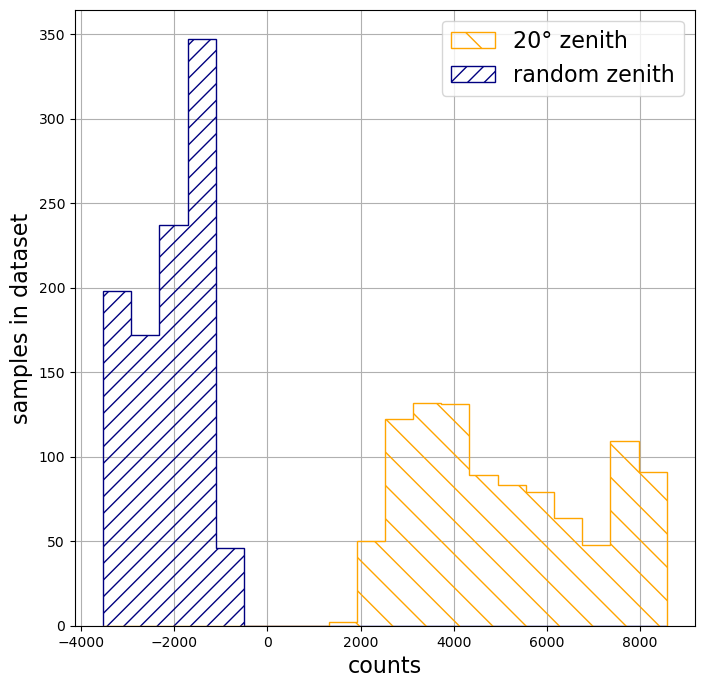

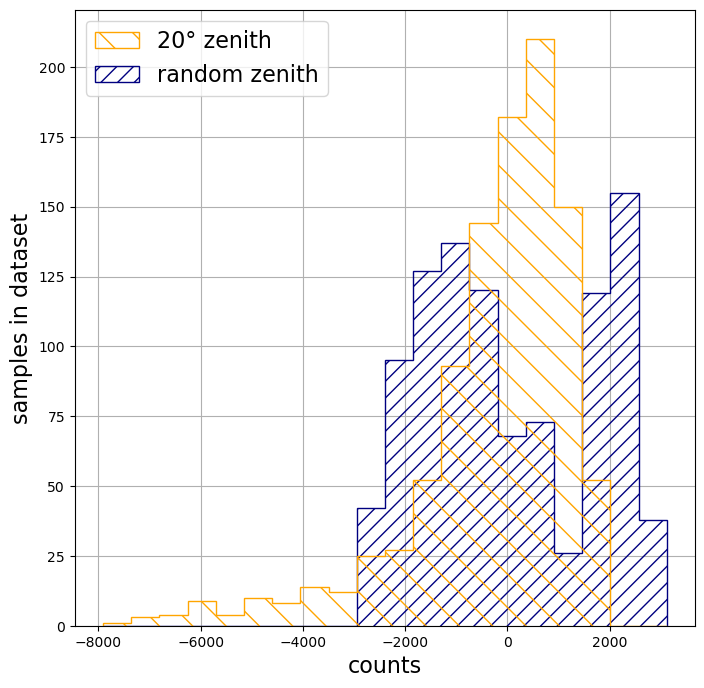

In [31]:
import matplotlib.patches as mpatches

colors = ['orange', 'navy']
labels = ['20° zenith', 'random zenith']
hatches = ['\\', '//']
legends = [mpatches.Patch(facecolor='none', edgecolor=colors[0], hatch=hatches[0]), 
           mpatches.Patch(facecolor='none', edgecolor=colors[1], hatch=hatches[1])]

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_residual_z20['CNN'], sum_residual_zALL['CNN'])
#ax.set_title('background residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(handles=legends, labels=labels, fontsize=fs)
ax.grid()
for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
plt.show()
fig.savefig(f'img/paper_cleaner_hist_sum_residuals_z20_vs_zALL.png')

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_original_and_diff_z20['DIFF'], sum_original_and_diff_zALL['DIFF'])
#ax.set_title('background residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(handles=legends, labels=labels, fontsize=fs)
ax.grid()
for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
plt.show()
fig.savefig(f'img/paper_cleaner_hist_bkg_residuals_z20_vs_zALL.png')

## CUMULATIVE FOV

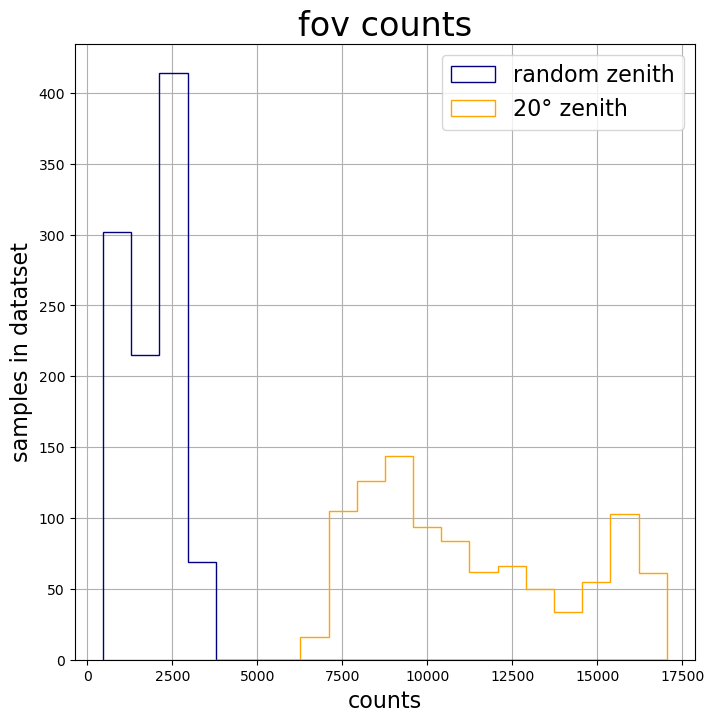

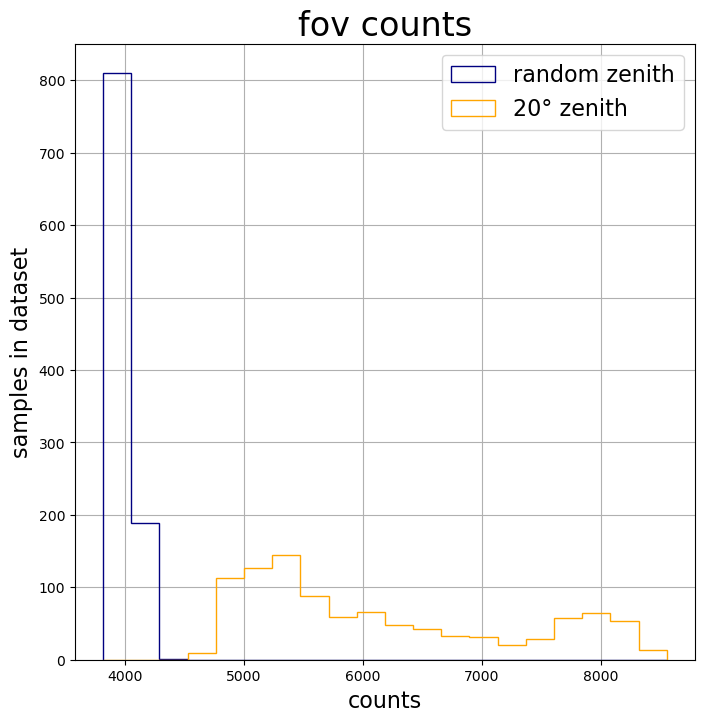

In [111]:
colors = ['orange', 'navy']
labels = ['20° zenith', 'random zenith']
hatches = ['\\', '//']
legends = [mpatches.Patch(facecolor='none', edgecolor=colors[0], hatch=hatches[0]), 
           mpatches.Patch(facecolor='none', edgecolor=colors[1], hatch=hatches[1])]

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_original_and_diff_z20['NOISY'], sum_original_and_diff_zALL['NOISY'])
#ax.set_title('fov counts', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors, label=labels)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in datatset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(handles=legends, labels=labels, fontsize=fs)
ax.grid() 
for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
plt.show()
#fig.savefig(f'img/paper_cleaner_hist_bkg_residuals_z20_vs_zALL.png')

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_fov_z20['CNN'], sum_fov_zALL['CNN'])
#ax.set_title('fov counts', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors, label=labels)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(handles=legends, labels=labels, fontsize=fs)
ax.grid()
for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
plt.show()
#fig.savefig(f'img/paper_cleaner_hist_bkg_residuals_z20_vs_zALL.png')

## EXCESS COUNTS

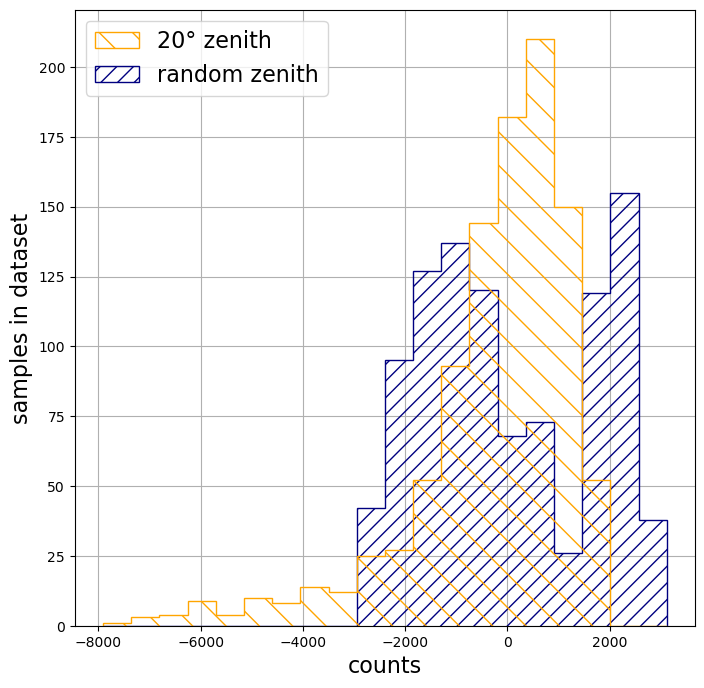

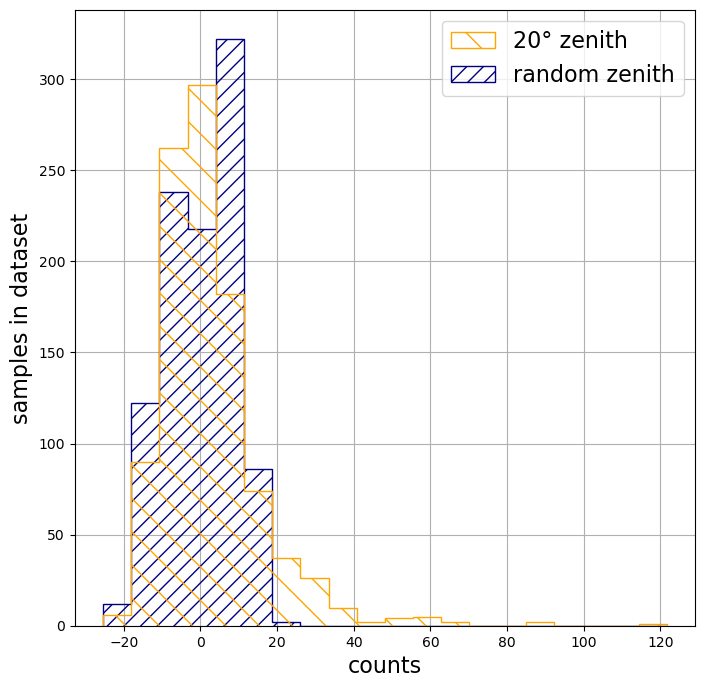

In [32]:
colors = ['orange', 'navy']
labels = ['20° zenith', 'random zenith']
hatches = ['\\', '//']
legends = [mpatches.Patch(facecolor='none', edgecolor=colors[0], hatch=hatches[0]), 
           mpatches.Patch(facecolor='none', edgecolor=colors[1], hatch=hatches[1])]

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_original_and_diff_z20['DIFF'], sum_original_and_diff_zALL['DIFF']) 
#ax.set_title('background residuals', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors, label=labels)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(handles=legends, labels=labels, fontsize=fs)
ax.grid()
for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
plt.show()
fig.savefig(f'img/paper_cleaner_hist_bkg_residuals_z20_vs_zALL.png')

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_on_region_z20['DIFF'], sum_on_region_zALL['DIFF'])
#ax.set_title('source excess', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 20, density=False, histtype='step', color=colors, label=labels)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(handles=legends, labels=labels, fontsize=fs)
ax.grid()
for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
plt.show()
fig.savefig(f'img/paper_cleaner_hist_excess_z20_vs_zALL.png')

# Statistics

In [ ]:
mean_z20 = np.mean(sum_original_and_diff_z20['DIFF'])
std_z20 = np.std(sum_original_and_diff_z20['DIFF'])
mean_zALL = np.mean(sum_original_and_diff_zALL['DIFF'])
std_zALL = np.std(sum_original_and_diff_zALL['DIFF'])

mean_z20 = np.mean(sum_on_region_z20['DIFF'])
std_z20 = np.std(sum_on_region_z20['DIFF'])
mean_zALL = np.mean(sum_on_region_zALL['DIFF'])
std_zALL = np.std(sum_on_region_zALL['DIFF'])

# PLOTS CNN vs STD

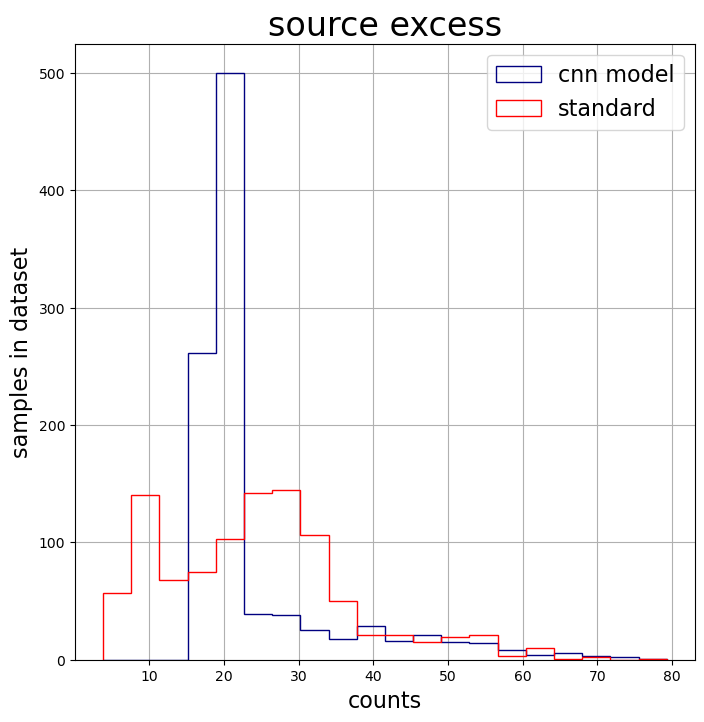

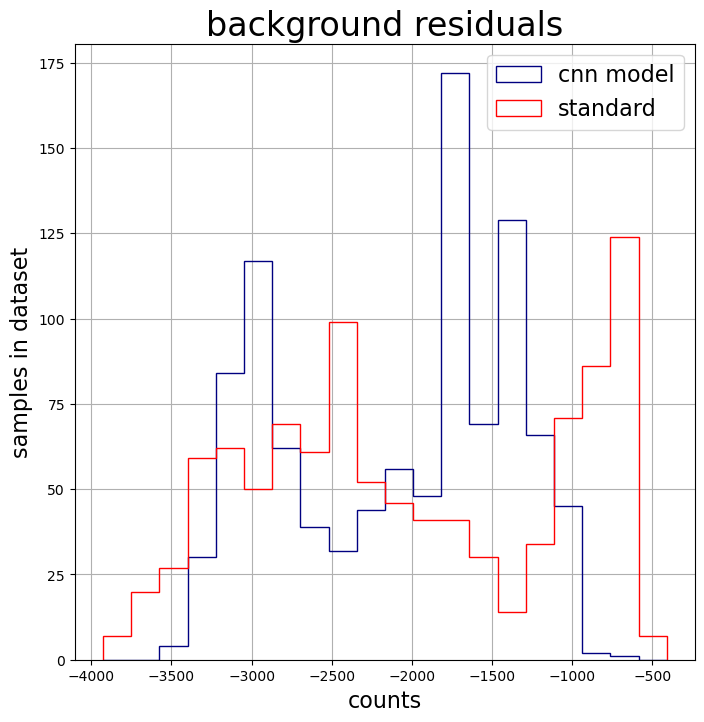

In [113]:
colors = ['red', 'navy']
labels = ['standard', 'cnn model']

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_on_region_zALL['STD'], sum_on_region_zALL['CNN'])
ax.set_title('source excess', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=labels)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()
plt.show()

# hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_residual_zALL['STD'], sum_residual_zALL['CNN'])
ax.set_title('background residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=labels)
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()
plt.show()